In [1]:
import os
import numpy as np
import sys
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
#get text email dataset, which is equal to the image email datset
TEXT_DATA_DIR = os.path.join(BASE_DIR, '')
print(TEXT_DATA_DIR)
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 200

nb_filters = 256
hiden_lstm_layer = 256

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.200d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {'ham':0, 'spam':1}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
                        
count = 0
for folder in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, folder)
    for fname in sorted(os.listdir(path)):
        if fname is not None:
            fpath = os.path.join(path, fname)
            args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
            with open(fpath, **args) as f:
                t = f.read()
                i = t.find('Subject:')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                count+=1
                print(count,":",t[0:30])
            if folder =='ham':
                labels.append(0)
                print('ham')
            else:
                labels.append(1)
                print('spam')
# print('Process text dataset done')
# print('count:',count)

/home/zsj/luoyang/spam_final/spam-experiment-paper/hybrid_email_dataset_equal/text/
Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
1 : Subject: palm pilot request
je
ham
2 : Subject: invoice processing
as
ham
3 : Subject: north baja project
ac
ham
4 : Subject: long term outlook
fyi
ham
5 : Subject: account assignment li
ham
6 : Subject: pg & e deliveries
her
ham
7 : Subject: travel announcement
e
ham
8 : Subject: pac enrollment
last y
ham
9 : Subject: ferc gives guardian f
ham
10 : Subject: [ fwd : re : graco co
ham
11 : Subject: nymex info on desktop
ham
12 : Subject: competing pipelines
o
ham
13 : Subject: organizational announ
ham
14 : Subject: a few items from jean
ham
15 : Subject: cera says average nat
ham
16 : Subject: tw cash for fuel issu
ham
17 : Subject: cera says average nat
ham
18 : Subject: contact list
please f
ham
19 : Subject: capacity options on t
ham
20 : Subject: cost of service annou
ham
21 : Subject: a simple communicatio
ham
22 : Subjec

864 : Subject: kindest attention
kin
spam
865 : Subject: greatest online medic
spam
866 : Subject: citibank alerting ser
spam
867 : Subject: xp pro $ 5 o , adobe 
spam
868 : Subject: brand name and generi
spam
869 : Subject: warren how could you 
spam
870 : Subject: bruceg , !
valiumxana
spam
871 : Subject: lo invitamos a conoce
spam
872 : Subject: best software prices 
spam
873 : Subject: reduc ^ e your mor ! 
spam
874 : Subject: greatest online medic
spam
875 : Subject: cheapest meds you ' l
spam
876 : Subject: cheap oem software sh
spam
877 : Subject: super vkiagra
generic
spam
878 : Subject: cheap online pills he
spam
879 : Subject: your source for onlin
spam
880 : Subject: nt 4 . 0 terminal ser
spam
881 : Subject: photoshop 7 + premier
spam
882 : Subject: we sell regalis for a
spam
883 : Subject: = ? utf - 8 ? q ? equ
spam
884 : Subject: 
when was the last ti
spam
885 : Subject: cheap online medicati
spam
886 : Subject: watch and learn about
spam
887 : Subject: even your appetite 

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Dropout, GRU   
VALIDATION_SPLIT=0.8
print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int( VALIDATION_SPLIT* data.shape[0])
# test_num=num_validation_samples+int(0.2* data.shape[0])
x_text_train = data[:num_validation_samples]
y_text_train = labels[:num_validation_samples]
# x_text_valid = data[num_validation_samples:val_num]
# y_text_valid = labels[num_validation_samples:val_num]
x_text_test = data[num_validation_samples:]
y_text_test = labels[num_validation_samples:]

print('x_train.shape',x_text_train.shape)
print('y_train.shape',y_text_train.shape)
# print('x_val.shape',x_text_valid.shape)
# print('y_val.shape',y_text_valid.shape)
print('x_test.shape',x_text_test.shape)
print('y_test.shape',y_text_test.shape)

Using TensorFlow backend.


Found 1200 texts.
Found 26464 unique tokens.
Shape of data tensor: (1200, 500)
Shape of label tensor: (1200, 2)
x_train.shape (960, 500)
y_train.shape (960, 2)
x_test.shape (240, 500)
y_test.shape (240, 2)


In [3]:
import keras, cv2,os
import numpy as np
from PIL import Image,ImageEnhance
from keras.utils import to_categorical
def read_image(path,imageName):
    img=cv2.imread(imageName,cv2.IMREAD_COLOR)
#     image=Image.open(imageName)
#     contrast = ImageEnhance.Contrast(image)
#     img=contrast.enhance(2)
#     img = np.asarray(img)
    #method1
    if img is None:
        os.remove(os.path.join(path,imageName))
        print("remove success")
        return None
    else:
        img = cv2.resize(img,dsize=(128,128),interpolation=cv2.INTER_LINEAR)
        img = img.astype("float32")
        img *= (1./255)
        b,g,r=cv2.split(img)
        img2=cv2.merge([r,g,b])
        
#         img *= (1./255)
#         r, g, b,a = cv2.split(img)
#         contrast=cv2.merge([b, g, r])
        return img2
        
def img_processing(path,x,y):
    directory =os.listdir(path)
    for textPath in directory:
        for fn in os.listdir(os.path.join(r"",path+ textPath)):
#             if fn.endswith('.png') or fn.endswith('.jpg'):
            fd = os.path.join(path, textPath, fn)
            img_arr=read_image(path,fd)
            if(img_arr is not None):
                x.append(img_arr)
                if(textPath=="ham"):
                    y.append(0)
# #                     img_arr.save(os.path.join(path+"\ham", os.path.basename(img_arr)))
#                         pass
                else:
                    y.append(1)
#                     img_arr.save(os.path.join(path+"\spam", os.path.basename(img_arr)))
#                         pass
    return x,y  
x,y=[],[]
#get image email dataset, which is equal to the text email datset
path1=""


x,y=img_processing(path1,x,y)
VALIDATION_SPLIT=0.8


data = np.array(x)

labels = to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int( VALIDATION_SPLIT* data.shape[0])
# val_num=num_validation_samples+int(0.2* data.shape[0])
x_img_train = data[:num_validation_samples]
y_img_train = labels[:num_validation_samples]
# x_img_valid = data[num_validation_samples:val_num]
# y_img_valid = labels[num_validation_samples:val_num]
x_img_test = data[num_validation_samples :]
y_img_test = labels[num_validation_samples :]

print('x_train.shape',x_img_train.shape)
print('y_train.shape',y_img_train.shape)
# print('x_valid.shape',x_img_valid.shape)
# print('y_valid.shape',y_img_valid.shape)
print('x_test.shape',x_img_test.shape)
print('y_test.shape',y_img_test.shape)

Shape of data tensor: (1200, 128, 128, 3)
Shape of labels tensor: (1200, 2)
x_train.shape (960, 128, 128, 3)
y_train.shape (960, 2)
x_test.shape (240, 128, 128, 3)
y_test.shape (240, 2)


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
img_model = load_model('image_cnn_model.h5')
text_model = load_model('lstm.h5')  
# text_model = load_model('lstm_hybrid.h5')   

In [5]:
img_prob=img_model.predict(x_img_train,batch_size=32, verbose=0)
text_prob = text_model.predict(x_text_train,batch_size=32, verbose=0)

In [6]:
text_scores= text_model.evaluate(x_text_train,y_text_train, batch_size=32)
print("\n%s: %.2f%%" % ("acc", text_scores[1]*100))

960/960 [==============================] - 5s 5ms/step

acc: 98.33%


In [7]:
img_scores= img_model.evaluate(x_img_train,y_img_train, batch_size=32)
print("\n%s: %.2f%%" % ("acc", img_scores[1]*100))

960/960 [==============================] - 1s 533us/step

acc: 96.88%


In [8]:
print("img_prob.shape",img_prob.shape)
print("text_prob.shape",text_prob.shape)

img_prob.shape (960, 2)
text_prob.shape (960, 2)


In [9]:
hybrid_data=np.concatenate((text_prob,img_prob), axis=1)
print(hybrid_data.shape)

(960, 4)


In [10]:
import keras
from keras import backend as K
from keras.layers import Activation, Dense
from keras.layers import merge
model = Sequential()  
model.add(Dense(64, input_shape=(4,)))
model.add(Activation('relu'))  
# model.add(Dense(32))
# model.add(Activation('relu'))  
model.add(Dense(2))
model.add(Activation('sigmoid')) 
model.compile(loss='binary_crossentropy',  optimizer='adam',
              metrics=['accuracy'])  
   
model.fit(hybrid_data, y_text_train, batch_size=32, epochs=20)
model.save("hybrid_for_equal.h5")

Epoch 1/20
960/960 [==============================] - 0s 223us/step - loss: 0.6307 - acc: 0.8891
Epoch 2/20
960/960 [==============================] - 0s 79us/step - loss: 0.5313 - acc: 0.9828
Epoch 3/20
960/960 [==============================] - 0s 73us/step - loss: 0.4303 - acc: 0.9828
Epoch 4/20
960/960 [==============================] - 0s 73us/step - loss: 0.3296 - acc: 0.9833
Epoch 5/20
960/960 [==============================] - 0s 77us/step - loss: 0.2408 - acc: 0.9833
Epoch 6/20
960/960 [==============================] - 0s 65us/step - loss: 0.1759 - acc: 0.9833
Epoch 7/20
960/960 [==============================] - 0s 74us/step - loss: 0.1357 - acc: 0.9833
Epoch 8/20
960/960 [==============================] - 0s 77us/step - loss: 0.1117 - acc: 0.9833
Epoch 9/20
960/960 [==============================] - 0s 77us/step - loss: 0.0972 - acc: 0.9833
Epoch 10/20
960/960 [==============================] - 0s 74us/step - loss: 0.0884 - acc: 0.9833
Epoch 11/20
960/960 [=================

In [11]:
img_prob_test=img_model.predict(x_img_test,batch_size=16)
text_prob_test= text_model.predict(x_text_test,batch_size=32, verbose=0)

print("img_prob_test.shape",img_prob_test.shape)
print("text_prob_test.shape",text_prob_test.shape)

hybrid_data_test=np.concatenate((text_prob_test, img_prob_test), axis=1)
print(hybrid_data_test.shape)

img_prob_test.shape (240, 2)
text_prob_test.shape (240, 2)
(240, 4)


In [12]:
scores= model.evaluate(hybrid_data_test,y_text_test, batch_size=32)
# print(acc)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

240/240 [==============================] - 0s 289us/step

acc: 98.75%


In [13]:
y_hybrid_score=model.predict(hybrid_data_test, 32)

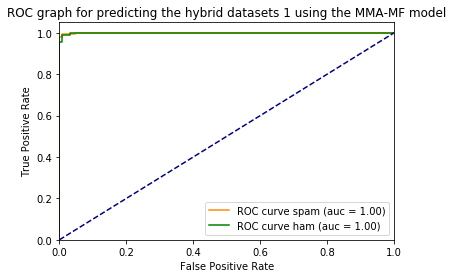

In [14]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

n_classes=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_text_test[:, i],y_hybrid_score[:, i])   
    roc_auc[i] = auc(fpr[i], tpr[i])    

# #Plot of a ROC curve for a specific class
# plt.rcParams['figure.figsize']=(8,5)
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve spam (auc = %0.2f)' % roc_auc[1])
plt.plot(fpr[0], tpr[0], color='green', label='ROC curve ham (auc = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC graph for predicting the hybrid datasets 1 using the MMA-MF model')  
plt.legend(loc="lower right")
plt.savefig('/home/zsj/luoyang/spam_final/spam-experiment-paper/ROC_graph_for_hybrid_dataset_equal.png')
plt.show()

In [15]:
from sklearn.metrics import classification_report
from sklearn import preprocessing   
import numpy as np
y_hybrid_pred = model.predict(hybrid_data_test,batch_size=32, verbose=0)
for i in range(len(y_hybrid_pred)):
    if(y_hybrid_pred[i][0]>0.5):
        y_hybrid_pred[i][0]=1
    else:
        y_hybrid_pred[i][0]=0
    if(y_hybrid_pred[i][1]>0.5):
        y_hybrid_pred[i][1]=1
    else:
        y_hybrid_pred[i][1]=0

print(classification_report(y_text_test,y_hybrid_pred))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       109
          1       0.98      0.99      0.99       131

avg / total       0.99      0.99      0.99       240



In [16]:
# get f1-score  & recall
from sklearn.metrics import f1_score,recall_score
print("f1_score：",f1_score(y_text_test,y_hybrid_pred,average = 'macro'))
print("recall_score：",recall_score(y_text_test,y_hybrid_pred,average = 'macro'))

f1_score： 0.9873841355504547
recall_score： 0.9870088941802647
